<b>支持向量机：</b><br/>
<b>优点：</b>泛化错误率低，计算开销不大，结果易解释。<br/>
<b>缺点：</b>对参数调节和核函数的选择敏感，原始分类器不加修改仅适用于处理二类问题。<br/>
<b>适用数据类型：</b>数值型和标称型<br/>

SMO优化算法  https://blog.csdn.net/c406495762/article/details/78072313

In [5]:
from numpy import *
from time import sleep
from os import listdir
import matplotlib.pyplot as plt
import numpy as np

In [8]:
#加载数据
def loadDataSet(fileName):
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat,labelMat

#数据可视化
def showDataSet(dataMat, labelMat):
    data_plus = []                                  #正样本
    data_minus = []                                 #负样本
    for i in range(len(dataMat)):
        if labelMat[i] > 0:
            data_plus.append(dataMat[i])
        else:
            data_minus.append(dataMat[i])
    data_plus_np = np.array(data_plus)              #转换为numpy矩阵
    data_minus_np = np.array(data_minus)            #转换为numpy矩阵
    plt.scatter(np.transpose(data_plus_np)[0], np.transpose(data_plus_np)[1])   #正样本散点图
    plt.scatter(np.transpose(data_minus_np)[0], np.transpose(data_minus_np)[1]) #负样本散点图
    plt.show()

#随机选择alpha   alpha的下标  alpha参数个数
def selectJrand(i,m):
    j=i #we want to select any J not equal to i
    while (j==i):
        j = int(random.uniform(0,m))
    return j

#修剪alpha  alpha值  alpha上限 alpha下限
def clipAlpha(aj,H,L):
    if aj > H: 
        aj = H
    if L > aj:
        aj = L
    return aj

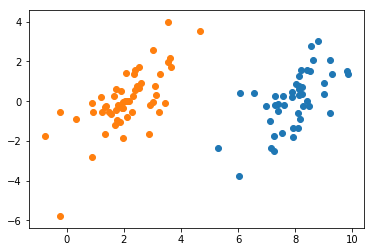

In [7]:
dataMat, labelMat = loadDataSet('testSet.txt')
showDataSet(dataMat, labelMat)

In [9]:
#简化版SMO算法  
"""
Parameters:
    dataMatIn - 数据矩阵
    classLabels - 数据标签
    C - 松弛变量
    toler - 容错率
    maxIter - 最大迭代次数
"""
def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    #转换为numpy的mat存储
    dataMatrix = np.mat(dataMatIn); labelMat = np.mat(classLabels).transpose()
    #初始化b参数，统计dataMatrix的维度
    b = 0; m,n = np.shape(dataMatrix)
    #初始化alpha参数，设为0
    alphas = np.mat(np.zeros((m,1)))
    #初始化迭代次数
    iter_num = 0
    #最多迭代matIter次
    while (iter_num < maxIter):
        alphaPairsChanged = 0
        for i in range(m):
            #步骤1：计算误差Ei
            fXi = float(np.multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[i,:].T)) + b
            Ei = fXi - float(labelMat[i])
            #优化alpha，更设定一定的容错率。
            if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):
                #随机选择另一个与alpha_i成对优化的alpha_j
                j = selectJrand(i,m)
                #步骤1：计算误差Ej
                fXj = float(np.multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[j,:].T)) + b
                Ej = fXj - float(labelMat[j])
                #保存更新前的aplpha值，使用深拷贝
                alphaIold = alphas[i].copy(); alphaJold = alphas[j].copy();
                #步骤2：计算上下界L和H
                if (labelMat[i] != labelMat[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                if L==H: print("L==H"); continue
                #步骤3：计算eta
                eta = 2.0 * dataMatrix[i,:]*dataMatrix[j,:].T - dataMatrix[i,:]*dataMatrix[i,:].T - dataMatrix[j,:]*dataMatrix[j,:].T
                if eta >= 0: print("eta>=0"); continue
                #步骤4：更新alpha_j
                alphas[j] -= labelMat[j]*(Ei - Ej)/eta
                #步骤5：修剪alpha_j
                alphas[j] = clipAlpha(alphas[j],H,L)
                if (abs(alphas[j] - alphaJold) < 0.00001): print("alpha_j变化太小"); continue
                #步骤6：更新alpha_i
                alphas[i] += labelMat[j]*labelMat[i]*(alphaJold - alphas[j])
                #步骤7：更新b_1和b_2
                b1 = b - Ei- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[i,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[i,:]*dataMatrix[j,:].T
                b2 = b - Ej- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[j,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[j,:]*dataMatrix[j,:].T
                #步骤8：根据b_1和b_2更新b
                if (0 < alphas[i]) and (C > alphas[i]): b = b1
                elif (0 < alphas[j]) and (C > alphas[j]): b = b2
                else: b = (b1 + b2)/2.0
                #统计优化次数
                alphaPairsChanged += 1
                #打印统计信息
                print("第%d次迭代 样本:%d, alpha优化次数:%d" % (iter_num,i,alphaPairsChanged))
        #更新迭代次数
        if (alphaPairsChanged == 0): iter_num += 1
        else: iter_num = 0
        print("迭代次数: %d" % iter_num)
    return b,alphas

In [10]:
"""
函数说明:分类结果可视化

Parameters:
    dataMat - 数据矩阵
    w - 直线法向量
    b - 直线解决
"""
def showClassifer(dataMat, w, b):
    #绘制样本点
    data_plus = []                                  #正样本
    data_minus = []                                 #负样本
    for i in range(len(dataMat)):
        if labelMat[i] > 0:
            data_plus.append(dataMat[i])
        else:
            data_minus.append(dataMat[i])
    data_plus_np = np.array(data_plus)              #转换为numpy矩阵
    data_minus_np = np.array(data_minus)            #转换为numpy矩阵
    plt.scatter(np.transpose(data_plus_np)[0], np.transpose(data_plus_np)[1], s=30, alpha=0.7)   #正样本散点图
    plt.scatter(np.transpose(data_minus_np)[0], np.transpose(data_minus_np)[1], s=30, alpha=0.7) #负样本散点图
    #绘制直线
    x1 = max(dataMat)[0]
    x2 = min(dataMat)[0]
    a1, a2 = w
    b = float(b)
    a1 = float(a1[0])
    a2 = float(a2[0])
    y1, y2 = (-b- a1*x1)/a2, (-b - a1*x2)/a2
    plt.plot([x1, x2], [y1, y2])
    #找出支持向量点
    for i, alpha in enumerate(alphas):
        if abs(alpha) > 0:
            x, y = dataMat[i]
            plt.scatter([x], [y], s=150, c='none', alpha=0.7, linewidth=1.5, edgecolor='red')
    plt.show()


"""
函数说明:计算w

Parameters:
    dataMat - 数据矩阵
    labelMat - 数据标签
    alphas - alphas值
"""
def get_w(dataMat, labelMat, alphas):
    alphas, dataMat, labelMat = np.array(alphas), np.array(dataMat), np.array(labelMat)
    w = np.dot((np.tile(labelMat.reshape(1, -1).T, (1, 2)) * dataMat).T, alphas)
    return w.tolist()

第0次迭代 样本:0, alpha优化次数:1
第0次迭代 样本:2, alpha优化次数:2
第0次迭代 样本:5, alpha优化次数:3
L==H
第0次迭代 样本:39, alpha优化次数:4
L==H
L==H
第0次迭代 样本:54, alpha优化次数:5
第0次迭代 样本:55, alpha优化次数:6
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 0
第0次迭代 样本:2, alpha优化次数:1
L==H
alpha_j变化太小
第0次迭代 样本:8, alpha优化次数:2
L==H
alpha_j变化太小
L==H
L==H
L==H
L==H
第0次迭代 样本:54, alpha优化次数:3
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
第0次迭代 样本:97, alpha优化次数:4
迭代次数: 0
alpha_j变化太小
第0次迭代 样本:5, alpha优化次数:1
第0次迭代 样本:10, alpha优化次数:2
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
L==H
迭代次数: 0
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
L==H
L==H
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
第0次迭代 样本:65, alpha优化次数:1
alpha_j变化太小
迭代次数: 0
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
第0次迭代 样本:54, alpha优化次数:1
alpha_j变化太小
alpha_j变化太小
L==H
L==H
迭代次数: 0
alpha_j变化太小
L==H
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
L==H
L==H
L==H
alpha_j变化太小
第0次迭代 样本:57, alpha优化次数:1
L==H
迭代次数: 0
alpha_j变

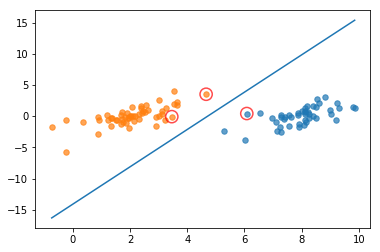

In [11]:
dataMat, labelMat = loadDataSet('testSet.txt')
b,alphas = smoSimple(dataMat, labelMat, 0.6, 0.001, 40)
w = get_w(dataMat, labelMat, alphas)
showClassifer(dataMat, w, b)

完整版SMO优化算法